In [1]:
import os

os.chdir(os.path.expanduser("~/l3_project"))
# for when on NCC to be able to import local packages

In [2]:

import platform

import matplotlib.pyplot as plt
import torch

import dataset_processing.eurosat
import dataset_processing.ucmerced

print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe MIG 1g.10gb to use as a cuda device.
Using cuda as torch device.


In [41]:
eurosat_train_ds = dataset_processing.eurosat.get_dataset("train", download=False)
eurosat_val_ds = dataset_processing.eurosat.get_dataset("val", download=False)

In [78]:
import plotly.express as px
import plotly.graph_objects as go
from umap import UMAP

In [5]:
[tuple(eurosat_train_ds[i].values()) for i in range(1)][0]

(tensor([[[1600., 1600., 1589.,  ..., 1086., 1117., 1100.],
          [1600., 1600., 1589.,  ..., 1086., 1117., 1100.],
          [1550., 1550., 1546.,  ..., 1100., 1102., 1103.],
          ...,
          [1523., 1523., 1509.,  ..., 1102., 1086., 1087.],
          [1420., 1420., 1382.,  ..., 1123., 1129., 1153.],
          [1314., 1314., 1286.,  ..., 1126., 1140., 1171.]],
 
         [[1291., 1291., 1281.,  ...,  978.,  982.,  988.],
          [1291., 1291., 1281.,  ...,  978.,  982.,  988.],
          [1257., 1257., 1262.,  ...,  990.,  981.,  978.],
          ...,
          [1244., 1244., 1225.,  ...,  977.,  972.,  979.],
          [1197., 1197., 1184.,  ..., 1001., 1009., 1023.],
          [1142., 1142., 1116.,  ..., 1015., 1014., 1033.]],
 
         [[1291., 1291., 1280.,  ..., 1083., 1098., 1087.],
          [1291., 1291., 1280.,  ..., 1083., 1098., 1087.],
          [1269., 1269., 1283.,  ..., 1093., 1080., 1091.],
          ...,
          [1271., 1271., 1250.,  ..., 1097., 1085

In [52]:
def get_n_samples(train_ds, val_ds, n=1000):
    train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=32, num_workers=4, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=32, num_workers=4, shuffle=True)

    train_tensor = torch.zeros(0)
    for i, x in enumerate(train_dataloader):
        if train_tensor.size(0) >= n:
            break
        train_tensor = torch.cat((train_tensor, x['image']), 0) if train_tensor.size else x['image']

    val_tensor = torch.zeros(0)
    val_labels_tensor = torch.zeros(0)
    for i, x in enumerate(val_dataloader):
        if val_tensor.size(0) >= n:
            break
        val_tensor = torch.cat((val_tensor, x['image']), 0) if val_tensor.size else x['image']
        val_labels_tensor = torch.cat((val_labels_tensor, x['label']), 0) if val_labels_tensor.size else x['label']

    text_val_labels = [train_ds.classes[int(i)] for i in val_labels_tensor]
    return train_tensor, val_tensor, val_labels_tensor, text_val_labels

In [6]:
train_data, val_data, val_labels, text_labels = get_n_samples(eurosat_train_ds, eurosat_val_ds, n=1000)
train_data.size(), val_labels.size()

(torch.Size([1024, 3, 64, 64]), torch.Size([1024]))

## Naive UMAP (just flattening all 3 channels and dimensions)

In [12]:
umap_2d = UMAP()
umap_2d.fit(train_data.flatten(1, -1).numpy())

/home2/jgcw74/miniconda3/envs/sat_project/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP(n_jobs=1, random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [13]:
projections = umap_2d.transform(val_data.flatten(1, -1).numpy())

fig = px.scatter(
    projections, x=0, y=1,
    color=text_labels, labels={'color': 'Class'}
)
fig.show()

## UMAP with PCA reduction

In [14]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=64).fit(train_data.flatten(1, -1).numpy())  # tried 50, 64, 100

In [36]:
train_data_reduced = pca.transform(train_data.flatten(1, -1).numpy())
val_data_reduced = pca.transform(val_data.flatten(1, -1).numpy())

In [37]:
umap_pca_2d = UMAP(n_neighbors=5)
umap_pca_2d.fit(train_data_reduced)

UMAP(n_neighbors=5, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [38]:
projections = umap_2d.transform(val_data_reduced)

fig = px.scatter(
    projections, x=0, y=1,
    color=text_labels, labels={'color': 'Class'}
)
fig.show()

## Multispectral

In [86]:
ndvi_bands = ('B04', 'B08')
ndwi_bands = ('B08', 'B03')
eurosat_train_ds_ms = dataset_processing.eurosat.get_dataset("train", bands=ndwi_bands, download=False)
eurosat_val_ds_ms = dataset_processing.eurosat.get_dataset("val", bands=ndwi_bands, download=False)

In [87]:
train_ms_data, val_ms_data, val_ms_labels, val_ms_text_labels = get_n_samples(eurosat_train_ds_ms, eurosat_val_ds_ms)

In [88]:
train_combo_data = train_ms_data.diff(dim=1).squeeze(1) / train_ms_data.sum(dim=1)
val_combo_data = val_ms_data.diff(dim=1).squeeze(1) / val_ms_data.sum(dim=1)

River


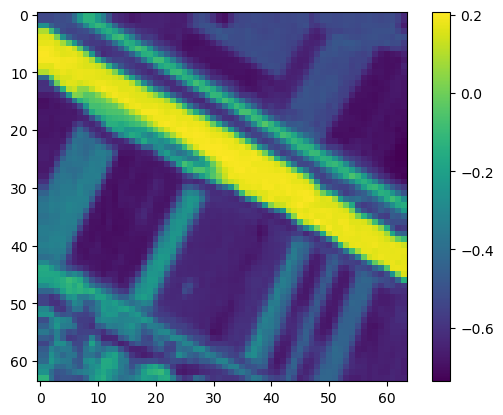

In [90]:
s = 0
plt.imshow(val_combo_data[s], cmap='viridis')
plt.colorbar()
print(val_ms_text_labels[s])

In [91]:
umap_ms = UMAP(n_neighbors=20, n_components=2)
umap_ms.fit(train_combo_data.flatten(1, -1).numpy())

UMAP(n_neighbors=20, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [92]:
projections = umap_ms.transform(val_combo_data.flatten(1, -1).numpy())
fig = px.scatter(
    projections, x=0, y=1,
    color=val_ms_text_labels, labels={'color': 'Class'}
)
fig.show()

In [93]:
umap_ms = UMAP(n_neighbors=20, n_components=3)
umap_ms.fit(train_combo_data.flatten(1, -1).numpy())

UMAP(n_components=3, n_neighbors=20, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [94]:
projections = umap_ms.transform(val_combo_data.flatten(1, -1).numpy())
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=val_ms_text_labels, labels={'color': 'Class'},
    size_max=1
)
fig.show()

In [85]:
fig = go.Figure(data=[go.Scatter3d(
    x=projections[:, 0],
    y=projections[:, 1],
    z=projections[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=val_labels,  # set color to an array/list of desired values
        colorscale='Rainbow',  # choose a colorscale
        opacity=0.8,
    ),
)])

fig.show()